<a href="https://colab.research.google.com/github/ApollineJauffret/github-flow/blob/master/notebooks/salomon_productfeed_rollout_042025_02_experiment_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Copyright 2024 Google LLC.*

*Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at*

     http://www.apache.org/licenses/LICENSE-2.0

*Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.*

# FeedX Experiment Analysis

[![Open in Colab](https://img.shields.io/badge/Open_in_Colab-blue?style=flat&logo=google%20colab&labelColor=grey)](https://colab.research.google.com/github/google-marketing-solutions/feedx/blob/main/notebooks/02_experiment_analyzer.ipynb)  
[![Open in Github](https://img.shields.io/badge/Open_in_Github-blue?style=flat&logo=Github&labelColor=grey)](https://github.com/google-marketing-solutions/feedx/blob/main/notebooks/02_experiment_analyzer.ipynb)  
[![Open in NBViewer](https://img.shields.io/badge/Open_in_NBViewer-blue?style=flat&logo=jupyter&labelColor=grey)](https://nbviewer.org/github/google-marketing-solutions/feedx/blob/main/notebooks/02_experiment_analyzer.ipynb)

Welcome to the FeedX experiment analysis. This notebook walks you through the process of analysing an in progress or completed FeedX experiment testing changes to your Merchant Center shopping feed. It will:

1. Load, process and validate the experiment data.
2. Load the experiment design from the yaml file produced by the experiment design notebook.
3. Load the treatment assignments data produced by the experiment design notebook.
4. Plot the performance of the metrics over time.
5. Analyse the overall relative and absolute impact of the experiment on the metrics, and estimate the statistical significance and confidence intervals.

## Install FeedX if not already installed

In [1]:
!pip install feedx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 1.6 MB/s eta 0:00:00


## Install packages

In [2]:
import tempfile
import textwrap

from feedx import experiment_analysis
from feedx import experiment_design
from feedx import data_preparation
from feedx import statistics
from feedx import plotting

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Authorise access to google drive (optional)

Run the cell below to allow access to data from google drive. This is only needed if you are loading the data from Google Drive, otherwise you can skip this cell. Upon running this cell, you will be asked to authenticate your google account, follow the steps and then return to this notebook.

In [3]:
from google.colab import auth
from google.auth import default
import gspread

auth.authenticate_user()
GOOGLE_CREDENTIALS, _ = default()
GSPREAD_CLIENT = gspread.authorize(GOOGLE_CREDENTIALS)

## Mount google drive (optional)

This cell mounts google drive to this Colab notebook. This is only needed if you are loading the data from a CSV stored in google drive (data loading options 3 or 4), it's not needed if you are loading the data from a Google Sheet.

In [4]:
from google.colab import drive

DRIVE_LOCATION = "/content/drive"
drive.mount(DRIVE_LOCATION)

Mounted at /content/drive


## Load Experiment Design

Here you need to load in the details of the experiment design that was run. This should have been output as a .yaml file by the experiment design notebook.

You can either load this directly from the yaml file that was generated from the experiment design, or copy and paste it's contents here. **You only need to do one of these options.**

*Note: If you are just testing this notebook with simulated data (using Option 1 below in the Load Experiment Data section), then just use Option 1 here and don't make any changes.*

### Option 1: Copy and paste experiment design yaml content here

If you want to copy and paste, you can just paste the content of your experiment design yaml file in the next cell (overwriting the example text that is already there). Again, if you are just testing this notebook with simulated data, run this cell without any changes.

In [5]:
with tempfile.NamedTemporaryFile("w", delete=False) as design_yaml_file:
    design_yaml_file.write(textwrap.dedent("""\
      alpha: 0.05
      coinflip_salt: None
      crossover_washout_weeks: 1
      is_crossover: true
      n_items_before_trimming: 13020
      pre_trim_top_percentile: 0.013
      pre_trim_bottom_percentile: 0.014
      n_items_after_pre_trim: 12669
      post_trim_percentile: 0.015
      n_items_after_post_trim: 12289
      power: 0.8
      pretest_weeks: 8
      primary_metric: impressions
      runtime_weeks: 8
    """))
    design_yaml_file.close()
    design = experiment_design.ExperimentDesign.load_from_yaml(design_yaml_file.name)

print(design)

Design 3206bcdec9e1e44d5cd10e7134099eab

	Experiment type: crossover experiment
	Primary metric: impressions
	Number of weeks of data before start of experiment used for analysis: 8
	Total experiment runtime weeks: 8

Crossover Details:

	Control and treatment to be swapped 4 weeks after starting the experiment
	Number of crossover washout weeks to ignore at start of each period: 1
	Weeks [1, 5] are the washout weeks to be excluded from the analysis

Number of items for testing:

	Number of items eligible for experimentation (before trimming): 13020

	Top 1.30% of items with highest impressions in pre-test period will not be included in experiment
	Bottom 1.40% items with lowest impressions in pre-test period will not be included in experiment
	Number of items remaining after trimming for the experiment: 12669

	Top and bottom 1.50% of items with highest / lowest impressions during experiment runtime will be excluded from the analysis
	Number of items remaining after trimming for the a

### Option 2: Load the experiment design directly from the yaml file

If you have uploaded the yaml file to colab, or you have stored it on Google Drive and mounted your google drive, then you can just provide the path to that file and load it from there.

In [ ]:
design_yaml_file_path = "" #@param {type:"string"}

design = experiment_design.ExperimentDesign.load_from_yaml(
    design_yaml_file_path
)

print(design)

## Load Experiment Data

Here you need to load in the performance data for the experiment items during the experiment. The data must be daily performance data, not weekly, and must contain the dates for the whole pre-test period and either the whole experiment runtime if the experiment has concluded, or if it has not then as much of the runtime as you have available.

**There are different options below for how you can load the data, depending on where it has been stored. You only need to run one, and you don't need to run the others.**

The data must contain at least the following three columns.

* Item ID: This is the identifier of the item
* Date: This is either the date for daily data, or the start of the week for weekly data.
* [Primary Metric]: This should be the value of your primary metric, for that item id on that date / week.

Optionally it can also contain other metrics as columns. Any columns that are redundant are ignored.

### Option 1: Create Synthetic Data

**DO NOT USE THIS FOR ANY REAL EXPERIMENTS.**

This option is just to demonstrate the notebook. It will generate daily synthetic data for a predefined experiment design. The random seed ensures that the data is the same each time the notebook runs.

In [ ]:
random_seed = 1234 #@param {type:"integer"}

rng = np.random.default_rng(random_seed)

metric_columns = ["clicks", "impressions", "total_cost", "conversions", "total_conversion_value"]
at_least_one_metrics = {
    "clicks": "at_least_one_click",
    "impressions": "at_least_one_impression",
    "conversions": "at_least_one_conversion"
}
metric_columns += list(at_least_one_metrics.values())
experiment_start_date = "2023-01-01"
experiment_has_concluded = True

# Load the performance data
daily_performance_data = data_preparation.generate_synthetic_data(
    rng=rng,
    n_items=design.n_items_after_pre_trim,
    start_date=experiment_start_date,
    weeks_before_start_date=design.pretest_weeks,
    weeks_after_start_date=design.runtime_weeks,
    impressions_average=50.0
)

# Load the treatment assignments
treatment_assignments = data_preparation.perform_treatment_assignment(
  daily_performance_data,
  design=design,
  rng=rng,
  item_id_column="item_id",
  week_id_column="week_id",
)

daily_experiment_data = data_preparation.prepare_and_validate_experiment_data(
    daily_performance_data=daily_performance_data,
    treatment_assignment_data=treatment_assignments,
    design=design,
    experiment_start_date=experiment_start_date,
    date_column="date",
    item_id_column="item_id",
    treatment_assignment_column="treatment_assignment",
    clicks_column="clicks",
    impressions_column="impressions",
    total_cost_column="total_cost",
    conversions_column="conversions",
    total_conversion_value_column="total_conversion_value",
    at_least_one_metrics=at_least_one_metrics,
    experiment_has_concluded=experiment_has_concluded,
)

daily_experiment_data = data_preparation.add_relative_effects_to_synthetic_data_for_demo(
    daily_experiment_data,
    time_period_column="time_period",
    treatment_assignment_column="treatment_assignment"
)

daily_experiment_data.head()

Using coinflip salt from design: abc123
Validation check 'no_sample_ratio_mismatch' passed. No Sample Ratio Mismatch.
Validation check 'primary_metric_in_metrics' passed. 
Validation check 'no_nulls' passed. 
Validation check 'no_duplicate_items_per_date' passed. All date have 600 item_id.
Validation check 'dates_are_daily_or_weekly' passed. Dates are daily.
Validation check 'week_ids_are_consecutive_integers' passed. Week ids are consecutive integers.
Validation check 'all_metrics_are_finite' passed. The following metric values are all finite: ['clicks', 'impressions', 'total_cost', 'conversions', 'total_conversion_value'].
Validation check 'all_metrics_are_non_negative' passed. The following metric values are all non-negative: ['clicks', 'impressions', 'total_cost', 'conversions', 'total_conversion_value'].
Validation check 'number_of_items_matches_design' passed. Number of items matches design, check passed.
Validation check 'experiment_dates_match_design' passed. Date range matches

,item_id,date,clicks,impressions,total_cost,conversions,total_conversion_value,week_id,week_start,time_period,at_least_one_click,at_least_one_impression,at_least_one_conversion,treatment_assignment
0,item_0,2023-01-01,0.0,4.4,0.0,0.0,0.0,0,2023-01-01,washout_1,0,1,0,1
1,item_0,2023-01-02,0.0,3.3,0.0,0.0,0.0,0,2023-01-01,washout_1,0,1,0,1
2,item_0,2023-01-03,0.0,1.1,0.0,0.0,0.0,0,2023-01-01,washout_1,0,1,0,1
3,item_0,2023-01-04,0.0,4.4,0.0,0.0,0.0,0,2023-01-01,washout_1,0,1,0,1
4,item_0,2023-01-05,0.0,5.5,0.0,0.0,0.0,0,2023-01-01,washout_1,0,1,0,1


### Option 2: Load data from a google sheet

Use this if your daily performance data and treatment assignments are stored in a Google Sheet on Google Drive. The two sheets will be joined on the item id column, so that column must be named the same in both sheets.

You must specify the following fields:

* **`performance_google_sheet_url`**: The URL to the google sheet containing the daily performance data.
* **`performance_worksheet_name`**: The name of the worksheet (tab) in that google sheet containing the performance data.
* **`treatment_assignment_google_sheet_url`**: The URL to the google sheet containing the treatment assignment data. This should contain a single row for each item, and two columns, one with the item id, and another with the treatment assignment that is always 0 or 1 (see below for more info).
* **`treatment_assignment_worksheet_name`**: The name of the worksheet (tab) in that google sheet containing the treatment assignment data.
* **`design_yaml_file_path`**: The path to the yaml file containing the design of this experiment. This can either be on Google Drive (if you've mounted it) or you can upload the yaml file directly.
* **`date_column_name`**: The name of the column containing the date.
* **`item_id_column_name`**: The name of the column containing the item identifiers in both the performance data and the treatment assignment data.
* **`clicks_column_name`**: The name of the column containing the clicks in the performance data. If you don't have clicks, leave this empty. It is required if the primary metric of your experiment is clicks.
* **`impressions_column_name`**: The name of the column containing the impressions in the performance data. If you don't have impressions, leave this empty. It is required if the primary metric of your experiment is impressions.
* **`total_cost_column_name`**: The name of the column containing the total cost in the performance data. If you don't have total cost, leave this empty. It is required if the primary metric of your experiment is total_cost.
* **`conversions_column_name`**: The name of the column containing the conversions in the performance data. If you don't have conversions, leave this empty. It is required if the primary metric of your experiment is conversions.
* **`total_conversion_value_column_name`**: The name of the column containing the total conversion value in the performance data. If you don't have total conversion value, leave this empty. It is required if the primary metric of your experiment is total_conversion_value.
* **`other_metrics_column_names`**: If you have any other metrics to analyse, you can add them here (comma separated if there are multiple).
* **`treatment_assignment_column_name`**: The name of the column containing the treatment assignments. These must be 0 if the item is in control and 1 if it is in treatment.
* **`experiment_start_date`**: The date the experiment started. Must be of the format YYYY-MM-DD.
* **`experiment_has_concluded`**: Selected if the experiment has concluded. If it has not concluded you can run the time evolution plots for monitoring but not the analysis.
* **`skip_validation_checks`**: The data validation checks that can be skipped (are allowed to fail). Typically this should be left blank, unless you have a good reason to skip a validation check.

The column containing the treatment assignments here will be either 0 or 1, and what this means depends on whether it is a crossover or non-crossover experiment:

* If the experiment was a **traditional (non-crossover) experiment**, then 0 means the item is in the control group and 1 means the item is in the treatment group.
* If the experiment was a **crossover experiment**, then 1 means the item was treated in the first half of the experiment and not treated in the second half, while 0 means the item was not treated in the first half of the experiment and was treated in the second half.

In [ ]:
performance_google_sheet_url = "" #@param {type:"string"}
performance_worksheet_name = "" #@param {type:"string"}

treatment_assignment_google_sheet_url = "" #@param {type:"string"}
treatment_assignment_worksheet_name = "" #@param {type:"string"}

date_column_name = "data_date" #@param {type:"string"}
item_id_column_name = "product_id" #@param {type:"string"}
clicks_column_name = "clicks" #@param {type:"string"}
impressions_column_name="impressions" #@param {type:"string"}
total_cost_column_name="cost" #@param {type:"string"}
conversions_column_name="conversions" #@param {type:"string"}
total_conversion_value_column_name="conversions_value" #@param {type:"string"}
other_metrics_column_names="" #@param {type:"string"}
treatment_assignment_column="treatment_assignment" #@param {type:"string"}
experiment_start_date = "2023-07-10" #@param {type:"string"}
experiment_has_concluded = True #@param {type:"boolean"}

skip_validation_checks = "" #@param {type:"string"}
skip_validation_checks = list(filter(lambda x: x, map(lambda x: x.strip(), skip_validation_checks.split(","))))

metric_columns = []
if clicks_column_name:
  metric_columns.append("clicks")
else:
  clicks_column_name = None

if impressions_column_name:
  metric_columns.append("impressions")
else:
  impressions_column_name = None

if total_cost_column_name:
  metric_columns.append("total_cost")
else:
  total_cost_column_name = None

if conversions_column_name:
  metric_columns.append("conversions")
else:
  conversions_column_name = None

if total_conversion_value_column_name:
  metric_columns.append("total_conversion_value")
else:
  total_conversion_value_column_name = None

if other_metrics_column_names:
  other_metrics = list(map(lambda x: x.strip(), other_metrics_column_names.split(",")))
  metric_columns.extend(other_metrics)
else:
  other_metrics = None


at_least_one_metrics = {
    "clicks": "at_least_one_click",
    "impressions": "at_least_one_impression",
    "conversions": "at_least_one_conversion"
}
at_least_one_metrics = {
    key: value
    for key, value in at_least_one_metrics.items()
    if key in metric_columns
}
metric_columns += list(at_least_one_metrics.values())


def load_data_from_google_sheet(url: str, worksheet_name: str, client: gspread.Client) -> pd.DataFrame:
  """Loads data from a Google Sheet to pandas dataframe."""
  input_sheet = client.open_by_url(url)

  if worksheet_name:
    values = input_sheet.worksheet(worksheet_name).get_all_values()
  else:
    values = input_sheet.sheet1.get_all_values()

  return pd.DataFrame.from_records(values[1:], columns=values[0])

# Load the performance data
daily_performance_data = load_data_from_google_sheet(
    url=performance_google_sheet_url,
    worksheet_name=performance_worksheet_name,
    client=GSPREAD_CLIENT
)

# Load the treatment assignments data
treatment_assignments = load_data_from_google_sheet(
    url=treatment_assignment_google_sheet_url,
    worksheet_name=treatment_assignment_worksheet_name,
    client=GSPREAD_CLIENT
)

# Create and validate the daily experiment data
daily_experiment_data = data_preparation.prepare_and_validate_experiment_data(
    daily_performance_data=daily_performance_data,
    treatment_assignment_data=treatment_assignments,
    design=design,
    experiment_start_date=experiment_start_date,
    date_column=date_column_name,
    item_id_column=item_id_column_name,
    treatment_assignment_column=treatment_assignment_column,
    clicks_column=clicks_column_name,
    impressions_column=impressions_column_name,
    total_cost_column=total_cost_column_name,
    conversions_column=conversions_column_name,
    total_conversion_value_column=total_conversion_value_column_name,
    other_metric_columns=other_metrics,
    at_least_one_metrics=at_least_one_metrics,
    experiment_has_concluded=experiment_has_concluded,
    skip_validation_checks=skip_validation_checks,
)

daily_experiment_data.head()

### Option 3: Load data from a CSV file

This is similar to loading from a google sheet, but use it if you are loading from a csv file that is either stored on google drive (and you've mounted google drive to this colab), or you've uploaded the CSVs directly to Colab.

The parameters are the same as for option 2, with the exception of the following:

* **`performance_file_path`**: The path to the file containing the daily performance data.
* **`treatment_assignment_file_path`**: The path to the file containing the treatment assignments.
* **`performance_header_rows`**: The row number in the performance CSV containing the column names (0 indexed). Any rows above this will be skipped.
* **`treatment_assignment_header_rows`**: The row number in the performance CSV containing the column names (0 indexed). Any rows above this will be skipped.
* **`thousands_separator`**: The separator for thousands in the csv. E.g. a comma means thousands are written like 1,000.

In [9]:
performance_file_path = "/content/drive/MyDrive/Colab Notebooks/Salomon/Product Feed Rollout/UK_product_performances_results_full_analysis_df.csv" #@param {type:"string"}
treatment_assignment_file_path = "/content/drive/MyDrive/Colab Notebooks/Salomon/Product Feed Rollout/UK_product_feed_rollout_feedx_treatment_assignment.csv" #@param {type:"string"}

performance_header_rows = 0 #@param {type:"number"}
treatment_assignment_header_rows = 0 #@param {type:"number"}

date_column_name = "Day" #@param {type:"string"}
item_id_column_name = "item_id" #@param {type:"string"}
clicks_column_name = "Clicks" #@param {type:"string"}
impressions_column_name="Impr." #@param {type:"string"}
total_cost_column_name="Cost" #@param {type:"string"}
conversions_column_name="Sales SA DDA" #@param {type:"string"}
total_conversion_value_column_name="Revenue SA DDA" #@param {type:"string"}
other_metrics_column_names="" #@param {type:"string"}
treatment_assignment_column="treatment_assignment" #@param {type:"string"}
experiment_start_date = "2025-02-26" #@param {type:"string"}
experiment_has_concluded = True #@param {type:"boolean"}

thousands_separator = "" #@param {type:"string"}
if thousands_separator == "":
  thousands_separator = None

skip_validation_checks = "no_nulls, coinflip_salt_validation" #@param {type:"string"}
skip_validation_checks = list(filter(lambda x: x, map(lambda x: x.strip(), skip_validation_checks.split(","))))

metric_columns = []
if clicks_column_name:
  metric_columns.append("clicks")
else:
  clicks_column_name = None

if impressions_column_name:
  metric_columns.append("impressions")
else:
  impressions_column_name = None

if total_cost_column_name:
  metric_columns.append("total_cost")
else:
  total_cost_column_name = None

if conversions_column_name:
  metric_columns.append("conversions")
else:
  conversions_column_name = None

if total_conversion_value_column_name:
  metric_columns.append("total_conversion_value")
else:
  total_conversion_value_column_name = None

if other_metrics_column_names:
  other_metrics = list(map(lambda x: x.strip(), other_metrics_column_names.split(",")))
  metric_columns.extend(other_metrics)
else:
  other_metrics = None


at_least_one_metrics = {
    "clicks": "at_least_one_click",
    "impressions": "at_least_one_impression",
    "conversions": "at_least_one_conversion"
}
at_least_one_metrics = {
    key: value
    for key, value in at_least_one_metrics.items()
    if key in metric_columns
}
metric_columns += list(at_least_one_metrics.values())

# Load the performance data
daily_performance_data = pd.read_csv(
    performance_file_path,
    header=performance_header_rows,
    thousands=thousands_separator
)

# Load the treatment assignments data
treatment_assignments = pd.read_csv(
    treatment_assignment_file_path,
    header=treatment_assignment_header_rows,
)



# Create and validate the daily experiment data
daily_experiment_data = data_preparation.prepare_and_validate_experiment_data(
    daily_performance_data=daily_performance_data,
    treatment_assignment_data=treatment_assignments,
    design=design,
    experiment_start_date=experiment_start_date,
    date_column=date_column_name,
    item_id_column=item_id_column_name,
    treatment_assignment_column=treatment_assignment_column,
    clicks_column=clicks_column_name,
    impressions_column=impressions_column_name,
    total_cost_column=total_cost_column_name,
    conversions_column=conversions_column_name,
    total_conversion_value_column=total_conversion_value_column_name,
    other_metric_columns=other_metrics,
    at_least_one_metrics=at_least_one_metrics,
    experiment_has_concluded=experiment_has_concluded,
    skip_validation_checks=skip_validation_checks,
)

daily_experiment_data.head()

Validation check 'primary_metric_in_metrics' passed. 
item_id                        0
date                           0
clicks                         0
impressions                    0
total_cost                     0
conversions                    0
total_conversion_value         0
week_id                        0
week_start                     0
time_period                25338
at_least_one_click             0
at_least_one_impression        0
at_least_one_conversion        0
treatment_assignment           0
dtype: int64

Validation check 'no_duplicate_items_per_date' passed. All date have 12,669 item_id.
Validation check 'dates_are_daily_or_weekly' passed. Dates are daily.
Validation check 'week_ids_are_consecutive_integers' passed. Week ids are consecutive integers.
Validation check 'all_metrics_are_finite' passed. The following metric values are all finite: ['clicks', 'impressions', 'total_cost', 'conversions', 'total_conversion_value'].
Validation check 'all_metrics_are_non_negat

,item_id,date,clicks,impressions,total_cost,conversions,total_conversion_value,week_id,week_start,time_period,at_least_one_click,at_least_one_impression,at_least_one_conversion,treatment_assignment
0,L1201170001,2025-01-07,0.0,1.0,0.0,0.0,0.0,-8,2025-01-01,pretest,0,1,0,0
1,L1201170001,2025-01-19,0.0,1.0,0.0,0.0,0.0,-6,2025-01-15,pretest,0,1,0,0
2,L1201170001,2025-01-26,0.0,1.0,0.0,0.0,0.0,-5,2025-01-22,pretest,0,1,0,0
3,L1201170001,2025-01-27,0.0,1.0,0.0,0.0,0.0,-5,2025-01-22,pretest,0,1,0,0
4,L1201170001,2025-02-02,0.0,1.0,0.0,0.0,0.0,-4,2025-01-29,pretest,0,1,0,0


## Plot the performance over time

This is useful for monitoring and just exploring what happened during your experiment. It shows for every metric the control and treatment performance over time, and the difference between control and treatment.

Note: for a crossover experiment, if the experiment has a positive impact, you would expect treatment to be better than control in the first period, but control to be better than treatment in the second period.

Below you can see the number of days in each time period of your data. Double check that is is what you expect, to make sure all the dates have lined up correctly.


In [11]:
(
    daily_experiment_data[["date", "time_period"]]
    .drop_duplicates()
    .groupby("time_period")
    .count()
    .rename({"date": "Number of Days in Time Period"}, axis=1)
)

,Number of Days in Time Period
time_period,
pretest,56
test_1,21
test_2,21
washout_1,7
washout_2,7


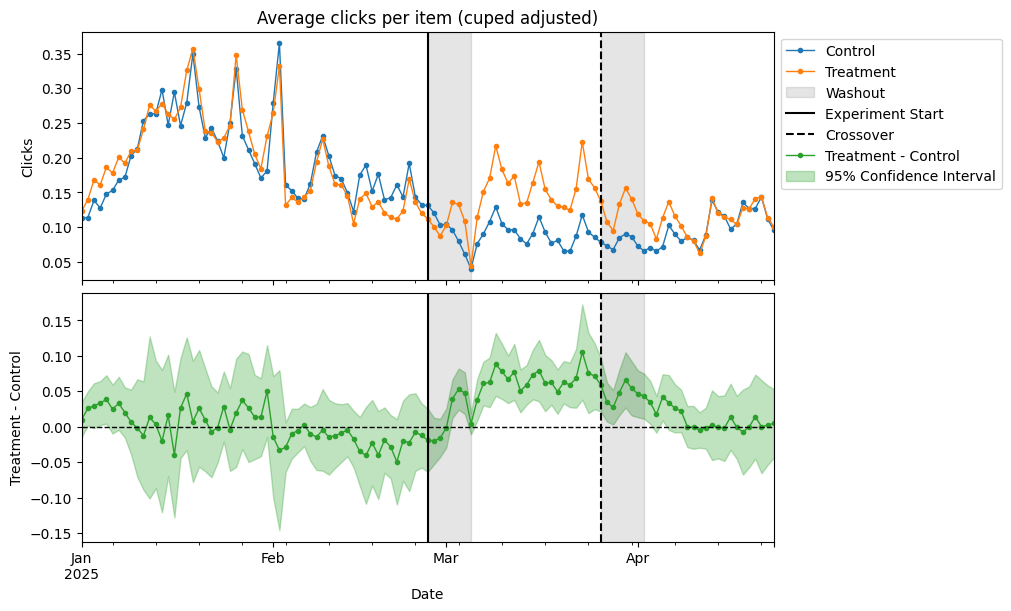

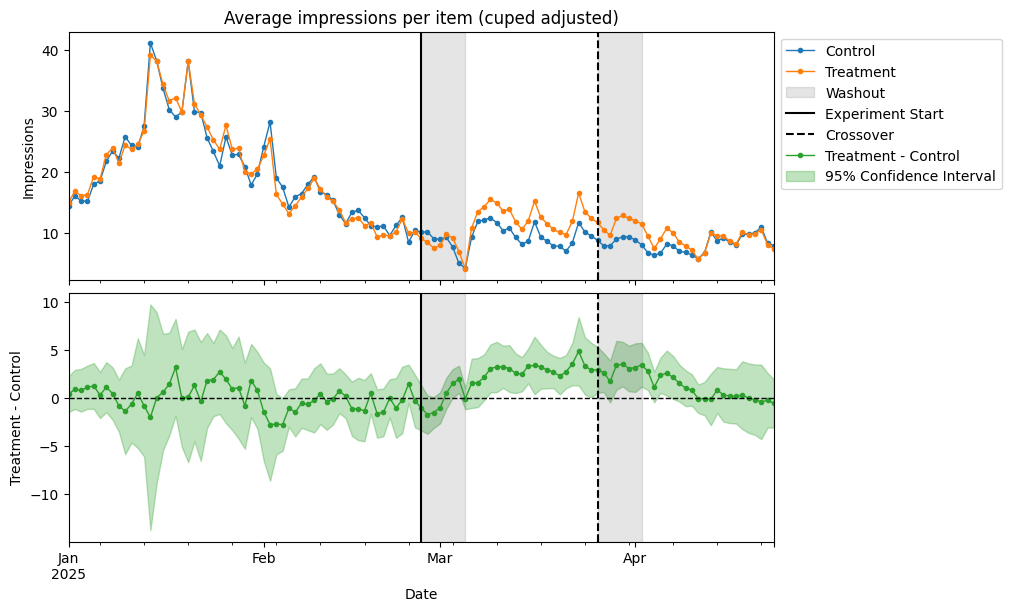

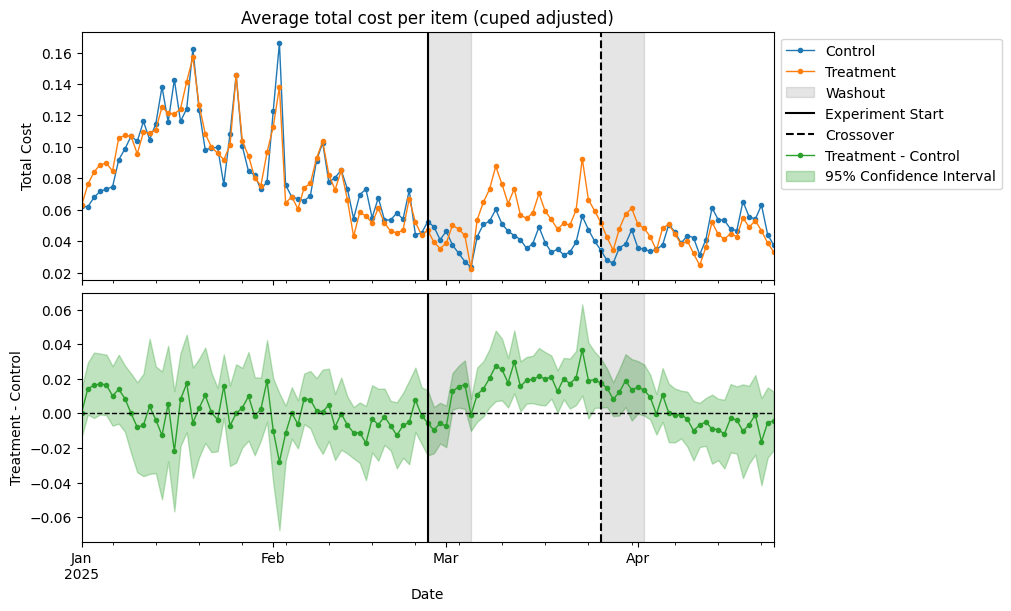

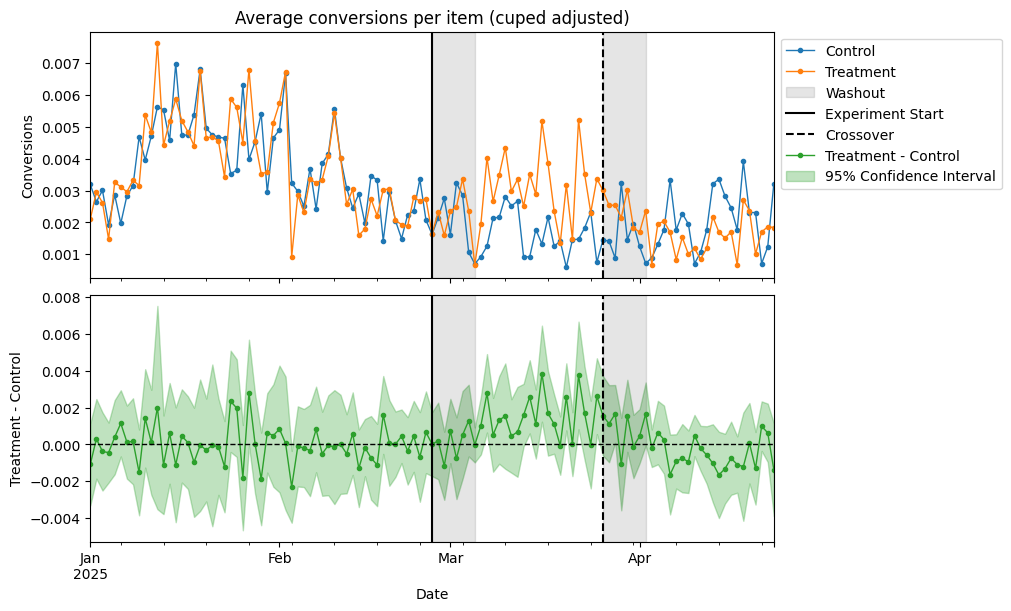

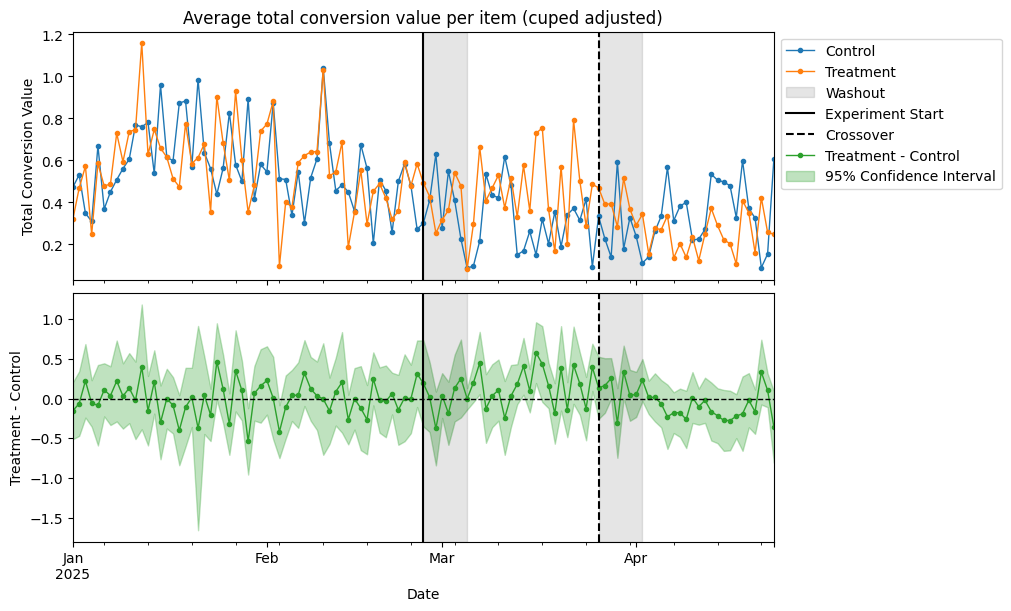

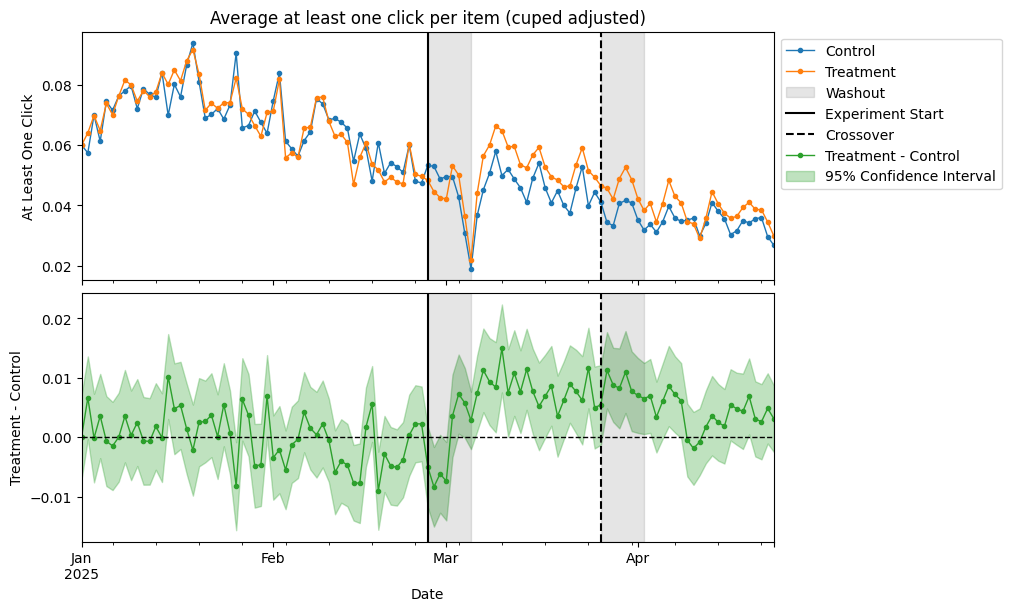

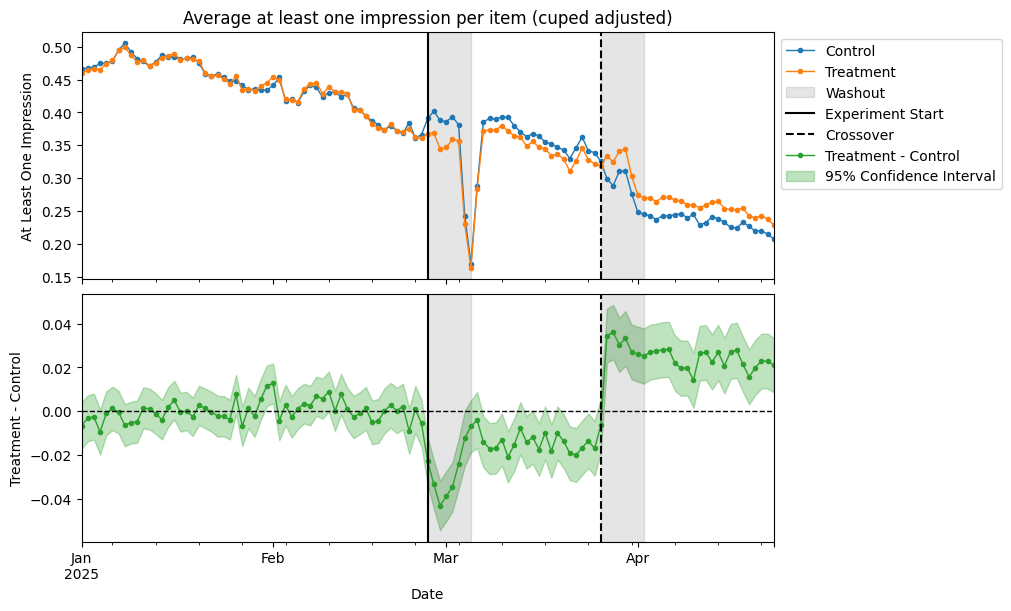

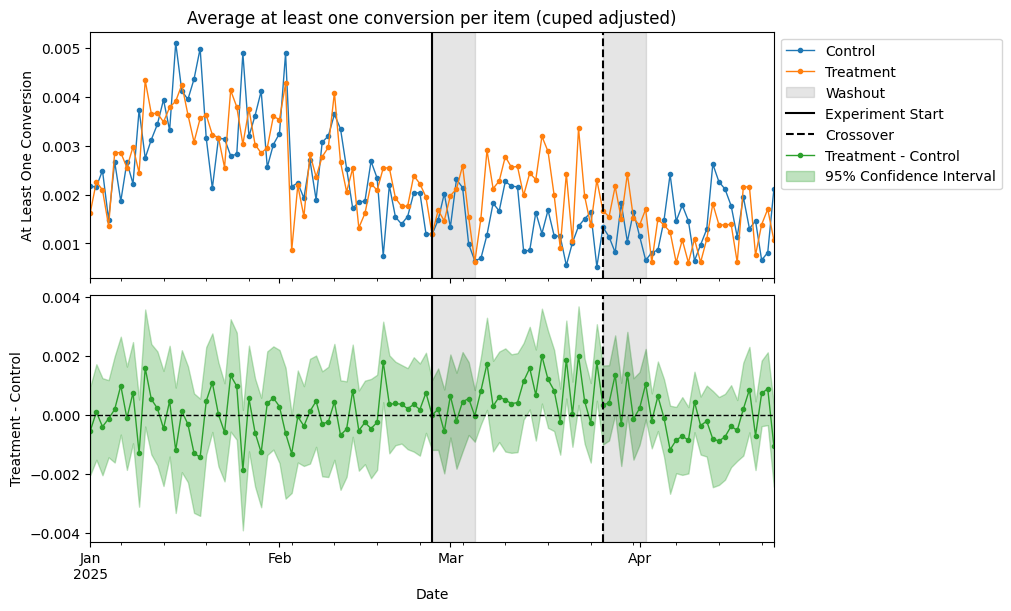

In [12]:
apply_cuped_adjustment_to_plots = True #@param {type:"boolean"}

for metric in metric_columns:
  fig, axs = plotting.plot_metric_over_time(
      daily_experiment_data,
      design=design,
      metric_column=metric,
      item_id_column="item_id",
      time_period_column="time_period",
      treatment_assignment_column="treatment_assignment",
      date_column="date",
      apply_cuped_adjustment=apply_cuped_adjustment_to_plots
  )
plt.show()

## Analysis

This section analyzes the experiment overall, to estimate the impact of the treatment on each metric. It estimates the relative and absolute impact, where the absolute impact is the change in the average value per item per week. E.g. for clicks is the change in the average clicks per item per week.

It will calculate the statistical significance of each metric, and metrics that are not statistically significant should **not** be considered as evidence that the treatment caused an impact in that metric. For more of a discussion on statistical significance, see the README.

For ratio metrics, the absolute difference is the "percentage point" difference expressed as a fraction, while the relative difference is the relative change in the ratio. For example, if in control the CTR was 0.5% and in treatment it was 0.8%, then the absolute difference would be +0.003 (which means 0.3 percentage points), while the relative difference would be +60% ((0.8 - 0.5) / 0.5)).

**NOTE: The results here are not reliable unless the experiment has completed it's runtime.**

If you would like to add more metrics, you need to add them in the `metrics` list.

## Trimming errors

When the experiment was designed, the design notebook tested different trimming levels and decided on the best possible level, and that is what is in the experiment design. However, this was designed for the primary metric, and it can be the case that for other metrics this trimming level doesn't work well. For example:

* For the "at least one..." metrics, these are binary. They are always either 0 or 1. So there cannot be any outliers here, and it doesn't make sense to do any trimming.
* If you designed the experiment for a higher volume metric like clicks, then the trimming threshold might be too high for a lower volume metric like conversions. For example, in an extreme case, if you have a trimming threshold of 1% and only 0.9% of your items get any conversions, then you will trim all of your converting items and everything remaining will be 0. In this case you can either not trim, or reduce the trimming threshold.

You can override the trimming threshold for any metric using the `trimming_quantile_override` argument. For example, setting this to 0 will turn off trimming, or setting it to 0.001 would trim by 0.1%. You shouldn't need to adjust the trimming on the primary metric, only on the other metrics.

## WARNING: Multiple comparisons and the primary metric

When running any A/B test, the more metrics you test, the more likely you are to find a false positive. This is [called multiple comparisons](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). This means that if you check all the metrics below, looking for anything that is positive, you will have a high chance of finding a false positive, not a real result.

**To mitigate this, we recommend using the primary metric as the main metric for your decision making.** This is the metric you used when you designed the experiment. All the other metrics should be considered supporting or exploratory, to help give a more complete picture. If your primary metric is not statistically significant and positive, but another metric is, the best practice is to run a follow up experiment to validate that finding rather than trusting it outright.

In [ ]:
metrics = [
    # Basic metrics
    experiment_analysis.Metric(name="Clicks", column="clicks"),
    experiment_analysis.Metric(name="Impressions", column="impressions"),
    experiment_analysis.Metric(name="Cost", column="total_cost"),
    experiment_analysis.Metric(name="Conversions", column="conversions"),
    experiment_analysis.Metric(name="Conversion value", column="total_conversion_value"),

    # For the "at least one" metrics we don't do trimming, the metrics are always 0 or 1,
    # there are no outliers.
    experiment_analysis.Metric(name="At least one impression", column="at_least_one_impression", trimming_quantile_override=0.0),
    experiment_analysis.Metric(name="At least one click", column="at_least_one_click", trimming_quantile_override=0.0),
    experiment_analysis.Metric(name="At least one conversion", column="at_least_one_conversion", trimming_quantile_override=0.0),

    # These are ratio metrics, so one metric divided by another,
    # so we also need to specify the denominator.
    experiment_analysis.Metric(name="CTR", column="clicks", denominator_column="impressions"),
    experiment_analysis.Metric(name="CPC", column="total_cost", denominator_column="clicks"),
    experiment_analysis.Metric(name="ROAS", column="total_conversion_value", denominator_column="total_cost"),
]

In [ ]:
experiment_results = experiment_analysis.analyze_experiment(
    daily_experiment_data.drop(columns="time_period"),
    design=design,
    metrics=metrics,
    week_id_column="week_id",
    treatment_assignment_column="treatment_assignment",
    item_id_column="item_id"
)

  0%|          | 0/11 [00:00<?, ?it/s]

Analysing Clicks
Analysing Impressions
Analysing Cost
Analysing Conversions
Analysing Conversion value
Analysing At least one impression
Analysing At least one click
Analysing At least one conversion
Analysing CTR
Analysing CPC
Analysing ROAS


In [ ]:
experiment_analysis.format_experiment_analysis_results_dataframe(experiment_results)

Below the impact is projected, to approximate the impact you would expect if this experiment was launched for the whole feed that was used for the experiment, for a whole year. This is a very naive projection, it simply multiplies the absolute effect size by the number of items in the experiment and by 52 for the number of weeks in a year. It does not account for seasonality in any way.

Additionally, if you have applied any pre or post trimming in this analysis, this projection will not be accounting for the impact on the trimmed items, so it may under-estimate the impact there.

The projection doesn't make sense for some metrics, for example the CTR cannot be projected in this way, since it is a ratio, it doesn't scale up wiht more items or a longer duration. We recommend only doing this projection for simple absolute metrics like clicks, impressions, cost, conversions or conversion value.

In [ ]:
merics_for_projection = [
    "Clicks",
    "Impressions",
    "Cost",
    "Conversions",
    "Conversion value",
]
experiment_analysis.format_experiment_analysis_results_dataframe(
    experiment_results.loc[experiment_results.index.isin(merics_for_projection)],
    include_yearly_projected_effect=True,
    include_relative_effect=False,
    include_absolute_effect=False
)

Finally, below the relative effects are visualised for easy comparison.

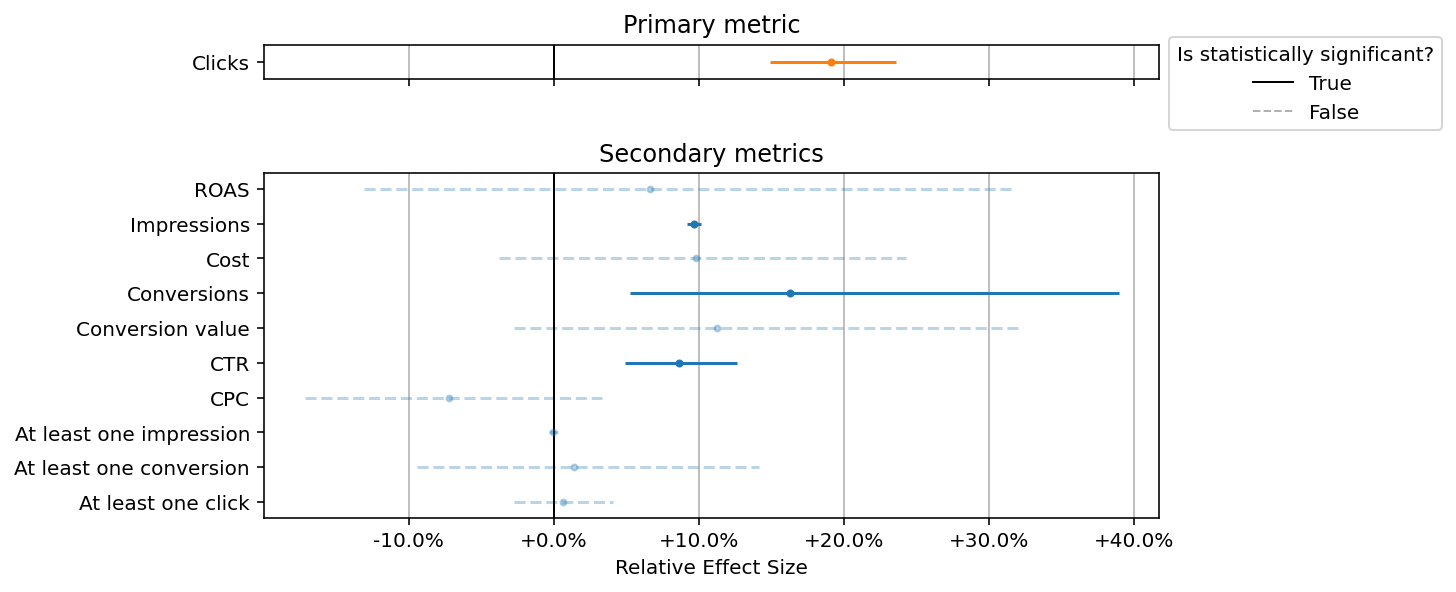

In [ ]:
plotting.plot_effects(experiment_results, design)
plt.show()